In [1]:
import numpy as np
import pandas as pd
from model.model import deepires_model
from model.sequence_encode import get_data_onehot
from Bio import SeqIO

In [2]:
test = np.load('./dataset/test/balanced_test_set.npz')
#test=np.load('C:/Users/czw20/Desktop/python/linear/iresite.npz')
X_tes,y_tes = test['X_tes'], test['y_tes']

In [3]:
np.unique(y_tes)

array([0, 1], dtype=int64)

In [4]:
model_outputs = pd.read_csv('./result/main.csv')
model_outputs.head()

,name,score,start,stop
0,ires0|0|,0.344378,1,174
1,ires1|0|,0.225371,1,174
2,ires2|0|,0.522480,1,174
3,ires3|0|,0.656356,1,174
4,ires4|0|,0.349786,1,174


In [5]:
# DeepIRES script code
def read_fa(path):
    res = {}
    records = list(SeqIO.parse(path, format='fasta'))
    for x in records:
        id = str(x.id)
        seq = str(x.seq)
        res[id] = seq
    return res

def predict_score(data):
    test = []
    start = []
    stop = []
    model = deepires_model()
    model.load_weights('weights/first').expect_partial()
    for seq in data:
        if (len(seq)) > 174:
            score = []
            i = 1
            while i + 173 <= len(seq):
                seqq = np.array(seq[i - 1:i + 173]).reshape(1, )
                x = get_data_onehot(seqq, maxlen=174)
                score.append(model.predict(x,verbose=0)[0][0])
                i = i + 50
            seqlast = np.array(seq[-174:]).reshape(1, )
            x1 = get_data_onehot(seqlast, maxlen=174)
            score.append(model.predict(x1,verbose=0)[0][0])
            max_score = max(score)
            max_index = score.index(max_score)
            test.append(max_score)
            if max_score == score[-1]:
                start.append(len(seq) - 173)
                stop.append(len(seq))
            else:
                startt = 50 * max_index + 1
                start.append(startt)
                stop.append(startt + 173)
        else:
            seqq = np.array(seq).reshape(1, )
            x = get_data_onehot(seqq, maxlen=174)
            test.append(model.predict(x,verbose=0)[0][0])
            start.append(1)
            stop.append(len(seq))
    return test, start, stop

In [6]:
name_t = []
seq_t = []
input_file = "main_independent.fa"

res = read_fa('./data/' + f'{input_file}')
for name in res.keys():
    name_t.append(name)
    seq_t.append(res[name].replace('U', 'T'))
score, start, stop = predict_score(seq_t)

In [7]:
print(f'{score}')

[0.3443784, 0.22537124, 0.5224803, 0.656356, 0.3497861, 0.057254918, 0.111464225, 0.81791294, 0.19116014, 0.40269116, 0.42510095, 0.30462408, 0.2708427, 0.19659081, 0.4357798, 0.36279365, 0.24958403, 0.14462061, 0.57186514, 0.14645992, 0.3514178, 0.25728652, 0.31430185, 0.45063323, 0.12385755, 0.6760992, 0.38190982, 0.37909618, 0.032806266, 0.5515145, 0.107988164, 0.3375609, 0.53837216, 0.2592658, 0.18379219, 0.33706057, 0.15125039, 0.39301184, 0.37129706, 0.07412281, 0.47025844, 0.89039695, 0.9027659, 0.93437785, 0.852544, 0.47345486, 0.49946263, 0.6385677, 0.1303749, 0.9717953, 0.7513938, 0.43105975, 0.93972266, 0.99271584, 0.63136864, 0.6823795, 0.13151431, 0.9995622, 0.1988467, 0.37821433, 0.6792847, 0.045965347, 0.8342652, 0.59774685, 0.49316907, 0.94975036, 0.888952, 0.8788644, 0.99867666, 0.9847725, 0.8648703, 0.85407525, 0.9937733, 0.91638935, 0.9695496, 0.99743575, 0.98535055, 0.21520312, 0.42161253, 0.36250848, 0.71930516, 0.5545519, 0.88804835, 0.5790956, 0.99902046, 0.70569

Code from `test_for_classification` to evaluate the performance of DeepIRES

In [8]:
import sys
sys.path.append("")

In [9]:
from sklearn.metrics import roc_auc_score, average_precision_score, f1_score,accuracy_score,recall_score,matthews_corrcoef,confusion_matrix,roc_curve, precision_recall_curve, auc
import numpy as np
import pandas as pd


In [10]:
# get y_pred_test npz
test_preds = np.load('./predictions/y_pred_test.npz')
y_pred_1 = test_preds['y_pred']

# get real results
test = np.load('./dataset/test/balanced_test_set.npz')
y_tes = test['y_tes']


In [11]:

y_pred=np.where(y_pred_1>0.5,1,0)
acc = accuracy_score(y_tes, y_pred)
sn = recall_score(y_tes, y_pred)
mcc = matthews_corrcoef(y_tes, y_pred)
tn, fp, fn, tp = confusion_matrix(y_tes, y_pred).ravel()
sp = tn / (tn + fp)
auroc = roc_auc_score(y_tes, y_pred_1)
f1 = f1_score(y_tes, y_pred.reshape(-1))
lr_precision, lr_recall, _ = precision_recall_curve(y_tes, y_pred_1)
aupr=auc(lr_recall,lr_precision)

print("ACC : ", acc)
print("SN : ", sn)
print("SP : ", sp)
print("MCC : ", mcc)
print("AUC : ", auroc)
print("F1-sorce : ", f1)
print("AUPR : ", aupr)

ACC :  0.7671957671957672
SN :  0.7248677248677249
SP :  0.8095238095238095
MCC :  0.5363167880704651
AUC :  0.7671957671957672
F1-sorce :  0.7569060773480663
AUPR :  0.8271706884423646


In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

#---------------------------------------
def model_plot(ground_truth,predictions):
    g = sns.jointplot(x=ground_truth,y=predictions,kind='scatter')
    g.plot_joint(sns.kdeplot, color="darkblue", zorder=1, levels=6)
    g.plot_joint(sns.regplot,scatter=False,color='black')
    plt.xlabel('Measured Function')
    plt.ylabel('Predicted Function')

ModuleNotFoundError: No module named 'seaborn'

In [ ]:
print(y_tes.shape)
print(y_pred.shape)
y_tes = y_tes[:, 0]
y_pred = y_pred[:, 0]
print(y_tes.shape)
print(y_pred.shape)

(378, 1)
(378, 1)
(378,)
(378,)


r2_score is: 0.06878306878306883
spearmanr is: SignificanceResult(statistic=np.float64(0.5363167880704652), pvalue=np.float64(1.5482437820025285e-29))
pearsonr is: PearsonRResult(statistic=np.float64(0.5363167880704651), pvalue=np.float64(1.548243782002609e-29))


c:\Users\jared\Anaconda3\envs\DeepIRES_Analysis\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\jared\Anaconda3\envs\DeepIRES_Analysis\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\jared\Anaconda3\envs\DeepIRES_Analysis\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\jared\Anaconda3\envs\DeepIRES_Analysis\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is de

AttributeError: 'QuadContourSet' object has no attribute 'collections'

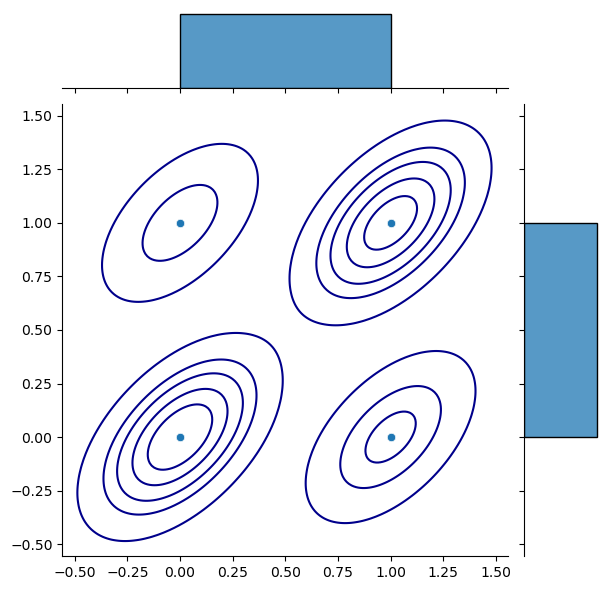

In [ ]:
# graphs
from sklearn.metrics import r2_score
from scipy.stats import spearmanr,pearsonr
import matplotlib.pyplot as plt

# y_pred defined above
r = spearmanr(y_tes,y_pred)

print('r2_score is:',r2_score(y_tes,y_pred))
print('spearmanr is:',spearmanr(y_tes,y_pred))
print('pearsonr is:',pearsonr(y_tes,y_pred))

# plt.figure(figsize=[6,4])
# plt.scatter(y_test[:,0],y_preds,alpha=0.1)
model_plot(y_tes,y_pred)
plt.suptitle('IRES Activity (R=%.3f)'%r[0])
# plt.suptitle('')
plt.xlabel('Experimental IRES activity')
plt.ylabel('Predicted IRES activity (SANDSTORM)')

testing our IRES data in their model to test performance

In [ ]:
name_t = []
seq_t = []
input_file = "main_independent.fa"

res = read_fa('./data/' + f'{input_file}')
for name in res.keys():
    name_t.append(name)
    seq_t.append(res[name].replace('U', 'T'))
score, start, stop = predict_score(seq_t)